# Вебинар 6. Двухуровневые модели рекомендаций


### Preprocess

Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('raw_data/retail_train.csv')
item_features = pd.read_csv('raw_data/product.csv')
user_features = pd.read_csv('raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
data_val_lvl_1.shape

(169711, 12)

In [5]:
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].values)]

In [6]:
data_val_lvl_1.shape

(169615, 12)

In [7]:
users_batch = data_val_lvl_1.user_id.unique()[:500]

data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(users_batch)]

In [8]:
data_val_lvl_1.shape

(60232, 12)

In [9]:
recommender = MainRecommender(data_train_lvl_1)

In [10]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1044078, 5569230, 844179]

In [11]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [12]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 1115576, 12781666]

In [13]:
recommender.get_similar_users_recommendation(2375, N=5)

[820612, 12523928, 5574377, 963686, 9245108]

### Задание 1

##### Описание

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [14]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,13,"[6544236, 822407, 908317, 1056775, 1066289, 11..."
1,19,"[1087916, 6534178, 859075, 883404, 940947, 944..."


##### Решение

A:

In [15]:
# Получаем actual.
def get_top_actual_by_interactions(df: pd.DataFrame):
    users = df.user_id.unique().tolist()
    user_actual = df.groupby('user_id')['item_id'].unique().reset_index()
    user_actual.columns=['user_id', 'actual']
    
    return user_actual

data = get_top_actual_by_interactions(data_val_lvl_1)

In [16]:
def calc_metrics(func, N, data: pd.DataFrame):
    data['candidates'] = data.apply(lambda row: func(row['user_id'], N=N), axis=1)

    data['recall_at_k'] = data.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=N), axis=1)
    return round(data['recall_at_k'].mean(), 5)
    
    
calc_metrics(func=recommender.get_als_recommendations,
             N=50,
             data=data)

0.04941

In [17]:
top_items = data_train_lvl_1.groupby('item_id')['quantity'].count().sort_values(ascending=False)[1:]

In [20]:
def get_own_plus_top_recommendations(user_id, N):
    rec = recommender.get_own_recommendations(user_id, N=N)
    if len(rec) < N:
        rec += top_items[:N-len(rec)].values.tolist()
    
    return rec

get_own_plus_top_recommendations(user_id=2375, N=10)

[948640,
 918046,
 847962,
 907099,
 873980,
 884694,
 10285454,
 1107760,
 7169090,
 979674]

B:

In [21]:
recommend_funcs = [recommender.get_als_recommendations, recommender.get_own_recommendations,
                   recommender.get_similar_items_recommendation, get_own_plus_top_recommendations]


Ns = {1, 2, 3, 4, 5, 7, 10, 20, 50, 100, 200, 500}

results = pd.DataFrame(columns=[func.__name__ for func in recommend_funcs], index=Ns)

for N in Ns:
    for func in recommend_funcs:
        m = calc_metrics(func=func, N=N, data=data)
        results.loc[N, func.__name__] = m
        print(f'{func.__name__}: {m}, N: {N}')

results.columns = [' '.join(func.split('_')[1:-1]) for func in results.columns]

get_als_recommendations: 0.00239, N: 1
get_own_recommendations: 0.00466, N: 1
get_similar_items_recommendation: 0.00095, N: 1
get_own_plus_top_recommendations: 0.00466, N: 1
get_als_recommendations: 0.00459, N: 2
get_own_recommendations: 0.00838, N: 2
get_similar_items_recommendation: 0.00166, N: 2
get_own_plus_top_recommendations: 0.00838, N: 2
get_als_recommendations: 0.00658, N: 3
get_own_recommendations: 0.01301, N: 3
get_similar_items_recommendation: 0.00254, N: 3
get_own_plus_top_recommendations: 0.01301, N: 3
get_als_recommendations: 0.00832, N: 4
get_own_recommendations: 0.0154, N: 4
get_similar_items_recommendation: 0.00347, N: 4
get_own_plus_top_recommendations: 0.0154, N: 4
get_als_recommendations: 0.01011, N: 5
get_own_recommendations: 0.0174, N: 5
get_similar_items_recommendation: 0.00468, N: 5
get_own_plus_top_recommendations: 0.0174, N: 5
get_als_recommendations: 0.07216, N: 100
get_own_recommendations: 0.09497, N: 100
get_similar_items_recommendation: 0.04954, N: 100
ge

In [22]:
results.sort_index(inplace=True)
results

,als,own,similar items,own plus top
1,0.00239,0.00466,0.00095,0.00466
2,0.00459,0.00838,0.00166,0.00838
3,0.00658,0.01301,0.00254,0.01301
4,0.00832,0.0154,0.00347,0.0154
5,0.01011,0.0174,0.00468,0.0174
7,0.0125,0.02098,0.00649,0.02098
10,0.01649,0.0252,0.00825,0.0252
20,0.02896,0.03791,0.01521,0.03791
50,0.04941,0.06453,0.03188,0.06453
100,0.07216,0.09497,0.04954,0.09497


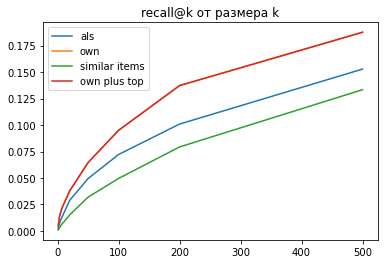

In [23]:
for func in results.columns:
    plt.plot(results[func])

plt.title(f'recall@k от размера k')
plt.legend(results.columns)

Own + top_popular не дают лучший recall, разбавление own top_popular снижает качество рекомендаций.

C:

Задача первого этапа двухэтапной рекомендательной системы - сократить кол-во объектов в обучающей выборке с одной стороны (чтобы получить разумную производительность на втором этапе) и предоставить для второго этапа достаточный выбор в разрезе каждого пользователя, чтобы как можно больше релевантных рекомендаций попало в выборку. При прочих равных в выборку попадает тем больше релевантных рекомендаций, чем в принципе в нее больше рекомендаций попадает. Соответственно, разумно выбирать какой-то промежуточный вариант (не очень большой и не очень маленький), например, 50. А если обобщенней, то размер должен определяться контекстом и... оптимизируемой метрикой. Если надо выжимать качество любой ценой, то надо увеличивать размер максимально возможно под лимиты производительности, если надо показывать хотя бы нормальное качество, но обучатсья быстро - другой контекст и т.д.

### Задание 2

##### Описание

Обучите модель 2-ого уровня, при этом:
    - A. Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - B. Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - C. Вырос ли precision@5 при использовании двухуровневой модели?
    

##### Решение

###### Предобработка

In [24]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [25]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [26]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [27]:
# Для валидационной выборки 2-го этапа.
targets_lvl_2v = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2v['target'] = 1  # тут только покупки 

targets_lvl_2v = users_lvl_2.merge(targets_lvl_2v, on=['user_id', 'item_id'], how='left')

targets_lvl_2v['target'].fillna(0, inplace= True)
targets_lvl_2v.drop('flag', axis=1, inplace=True)

In [28]:
targets_lvl_2['target'].mean()

0.10460593102333061

In [29]:
item_features.head(5)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


###### Добавляю признаки на основе items

In [30]:
item_features['department'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [31]:
department_rareness = item_features.groupby('department')['item_id'].count()

In [32]:
department_rareness /= department_rareness.max()

In [33]:
department_rareness.sort_values(ascending=False).head()

department
GROCERY      1.000000
DRUG GM      0.808001
PRODUCE      0.079906
COSMETICS    0.077164
NUTRITION    0.074678
Name: item_id, dtype: float64

In [34]:
item_features['dep_rareness'] = item_features['department'].map(dict(department_rareness))

In [35]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1.000000
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.012557
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,0.055073
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1.000000
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,1.000000


In [36]:
item_features['rare_private'] = 0

item_features.loc[(item_features['dep_rareness'] < 0.1) & (item_features['brand'] == 'Private'), 'rare_private'] = 1

In [37]:
item_features['rare_private'].mean()

0.026647753727545395

In [38]:
item_features['brand'].unique()

array(['National', 'Private'], dtype=object)

###### Добавляю признаки на основе users

In [39]:
user_features.head(5)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [40]:
user_features.loc[~user_features['hh_comp_desc'].str.contains('No Kids')].head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [41]:
user_features['hh_comp_desc'].unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [42]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

In [43]:
user_features['household_size'] = user_features['household_size_desc'].map({'1': 1, '2': 2, '3': 3, '4': 4, '5+': 5})

In [44]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,household_size
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,3


In [45]:
income_desc = user_features['income_desc'].unique()

income_desc

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [46]:
income_desc = income_desc.tolist()
income_desc = dict(zip(income_desc, [42, 62, 30, 87, 7, 112, 20, 137, 162, 350, 187, 225]))

income_desc

{'35-49K': 42,
 '50-74K': 62,
 '25-34K': 30,
 '75-99K': 87,
 'Under 15K': 7,
 '100-124K': 112,
 '15-24K': 20,
 '125-149K': 137,
 '150-174K': 162,
 '250K+': 350,
 '175-199K': 187,
 '200-249K': 225}

In [47]:
user_features['homeowner_desc'].unique()

array(['Homeowner', 'Unknown', 'Renter', 'Probable Renter',
       'Probable Owner'], dtype=object)

In [48]:
user_features['home_owner'] = 0

user_features.loc[user_features['homeowner_desc'].isin(['Homeowner', 'Probable Owner']), 'home_owner'] = 1

In [49]:
user_features['income_per_person'] = user_features['income_desc'].map(income_desc) / user_features['household_size']

In [50]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,household_size,home_owner,income_per_person
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2,1,21.00
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2,1,31.00
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,3,0,10.00
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,4,1,21.75
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,1,1,62.00


###### Добавляю признаки на основе users-items

In [51]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,...,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.808001,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.808001,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0


In [52]:
targets_lvl_2v = targets_lvl_2v.merge(item_features, on='item_id', how='left')
targets_lvl_2v = targets_lvl_2v.merge(user_features, on='user_id', how='left')

targets_lvl_2v.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,...,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.808001,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.808001,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0


In [53]:
user_dep_count = dict(targets_lvl_2.groupby('user_id')['department'].nunique())

targets_lvl_2['unique_dep_count_per_user'] = targets_lvl_2['user_id'].map(user_dep_count)

targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person,unique_dep_count_per_user
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6


In [54]:
user_dep_count = dict(targets_lvl_2v.groupby('user_id')['department'].nunique())

targets_lvl_2v['unique_dep_count_per_user'] = targets_lvl_2v['user_id'].map(user_dep_count)

targets_lvl_2v.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person,unique_dep_count_per_user
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6


In [55]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person,unique_dep_count_per_user
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.808001,...,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6


In [56]:
targets_lvl_2['income_per_unique_dep_count'] =\
targets_lvl_2['income_per_person'] / targets_lvl_2['unique_dep_count_per_user']

In [57]:
targets_lvl_2v['income_per_unique_dep_count'] =\
targets_lvl_2v['income_per_person'] / targets_lvl_2v['unique_dep_count_per_user']

In [58]:
targets_lvl_2['income_per_unique_dep_count'] /= targets_lvl_2['income_per_unique_dep_count'].max()

In [59]:
targets_lvl_2v['income_per_unique_dep_count'] /= targets_lvl_2v['income_per_unique_dep_count'].max()

In [60]:
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person,unique_dep_count_per_user,income_per_unique_dep_count
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619


In [61]:
targets_lvl_2v.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person,unique_dep_count_per_user,income_per_unique_dep_count
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619


In [62]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [63]:
X_test = targets_lvl_2v.drop('target', axis=1)
y_test = targets_lvl_2v[['target']]

In [64]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'dep_rareness',
 'rare_private',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'household_size',
 'home_owner',
 'income_per_person',
 'unique_dep_count_per_user',
 'income_per_unique_dep_count']

In [65]:
X_test[cat_feats] = X_test[cat_feats].astype('category')


In [66]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)
test_preds = lgb.predict_proba(X_test)

C:\Users\Mihail\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mihail\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [67]:
lgb.classes_

array([0., 1.])

###### ROC_AUC

Train roc_auc

In [68]:
roc_auc_score(y_train, [val[1] for val in train_preds])

0.8717864707413417

Test roc_auc

In [69]:
roc_auc_score(y_test, [val[1] for val in test_preds])

0.7804710800525656

###### Precision@k, вычисления

In [70]:
X_test.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,rare_private,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person,unique_dep_count_per_user,income_per_unique_dep_count
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,1,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,0,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
2,2070,879194,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,0,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
3,2070,948640,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.808001,0,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619
4,2070,928263,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.808001,0,...,50-74K,Unknown,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619


In [71]:
y_test.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [72]:
y_all = X_test.copy()
y_all['actual'] = y_test.astype(int)
y_all['predict'] = [val[1] for val in test_preds]

y_all.head(3)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,dep_rareness,rare_private,...,hh_comp_desc,household_size_desc,kid_category_desc,household_size,home_owner,income_per_person,unique_dep_count_per_user,income_per_unique_dep_count,actual,predict
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.060326,1,...,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619,0,0.090754
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.000000,0,...,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619,0,0.036578
2,2070,879194,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.808001,0,...,Unknown,1,None/Unknown,1.0,0.0,62.0,6,0.147619,0,0.092429


In [73]:
y_all.loc[y_all['actual'] == 1, 'predict'].mean(), y_all.loc[y_all['actual'] == 0, 'predict'].mean()

(0.24862551499042132, 0.08730418280110891)

In [74]:
N = 5

In [75]:
# ТОП N позиций по величине вероятности предикта бустинговой модели.
def top_n_items_by_predict(row, N):
    return row.sort_values(by='predict', ascending=False)['item_id'].tolist()[:N]

test_predict_top =\
y_all.groupby('user_id')[['predict', 'item_id']].apply(lambda row: top_n_items_by_predict(row, N=N)).reset_index()
test_predict_top.rename(columns={0: 'predict_top'}, inplace=True)

test_predict_top.head()

,user_id,predict_top
0,1,"[9655212, 10457591, 8293439, 8293439, 9297615]"
1,2,"[898847, 904236, 847241, 862725, 9416729]"
2,4,"[883932, 1079528, 939907, 992151, 921504]"
3,6,"[900802, 1098844, 6979393, 1084036, 12757544]"
4,7,"[1122358, 1122358, 1122358, 990897, 902640]"


In [76]:
# ТОП N позиций по продажам в разрезе юзеров.
def top_n_items_by_count(row, N):
    gr = row.groupby('item_id').count()
    gr.sort_values(by='predict', ascending=False, inplace=True)
#     print(gr.index[:N].tolist())
    
    return gr.index[:N].tolist()

test_sales_top =\
y_all.groupby('user_id')[['item_id', 'predict']].apply(lambda row: top_n_items_by_count(row, N=N)).reset_index()

test_sales_top.rename(columns={0: 'user_sales_top'}, inplace=True)

test_sales_top.head()

,user_id,user_sales_top
0,1,"[8293439, 856942, 825123, 1124029, 1131115]"
1,2,"[820301, 1131625, 1056620, 1056933, 1066391]"
2,4,"[822178, 5568447, 1075368, 1079528, 1090711]"
3,6,"[819308, 9368501, 1098844, 1108094, 1123254]"
4,7,"[1122358, 993838, 851066, 7147142, 1118036]"


In [77]:
test_tops = test_predict_top.merge(test_sales_top, on='user_id', how='inner')

test_tops.head(3)

,user_id,predict_top,user_sales_top
0,1,"[9655212, 10457591, 8293439, 8293439, 9297615]","[8293439, 856942, 825123, 1124029, 1131115]"
1,2,"[898847, 904236, 847241, 862725, 9416729]","[820301, 1131625, 1056620, 1056933, 1066391]"
2,4,"[883932, 1079528, 939907, 992151, 921504]","[822178, 5568447, 1075368, 1079528, 1090711]"


In [78]:
test_tops['precision@k'] = test_tops.apply(lambda row: precision_at_k(row['predict_top'],
                                                                      row['user_sales_top'],
                                                                      k=N), axis=1)

test_tops.head(3)

,user_id,predict_top,user_sales_top,precision@k
0,1,"[9655212, 10457591, 8293439, 8293439, 9297615]","[8293439, 856942, 825123, 1124029, 1131115]",0.2
1,2,"[898847, 904236, 847241, 862725, 9416729]","[820301, 1131625, 1056620, 1056933, 1066391]",0.0
2,4,"[883932, 1079528, 939907, 992151, 921504]","[822178, 5568447, 1075368, 1079528, 1090711]",0.2


###### Precision@k по итогам 2-х уровневой модели

In [79]:
test_tops['precision@k'].mean()

0.13593677359367484

###### Precision@k после 1-го уровня

In [97]:
def calc_metrics(func, N, data: pd.DataFrame):
    data['precision_at_k'] = data.apply(lambda row: precision_at_k(row['candidates'], row['actual'], k=N),
                                        axis=1)
    return round(data['precision_at_k'].mean(), 5)
    
    
calc_metrics(func=recommender.get_own_recommendations,
             N=5,
             data=data)

0.2548

Presision@k при добавлении второго этапа ухудшился - похоже, где-то ошибка закралась.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 

**Внимание**
Позже будет добавлено требование по метрике MAP@5